In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from src.Agent import PPOAgent
from src.OptimizerParameters import AdamOptimizerParameters

In [4]:
# General Hyperparams
gamma = 0.99
lmbda = 0.925
epsilon = 0.2  
num_policy_epochs = 5
num_value_epochs = 5
num_multihead_epochs = 5
smoothing_const = 1e-8
normalize_advantages = True
batch_size = 32
shuffle_batches = True
max_game_length = 500
num_episodes = 40

env = gym.make(id='CartPole-v1', max_episode_steps=max_game_length)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n

# Optimizer Hyperparams
policy_optimizer_parameters = AdamOptimizerParameters(lr=0.005, betas=(0.9, 0.999), weight_decay=0)
value_optimizer_parameters = AdamOptimizerParameters(lr=0.005, betas=(0.9, 0.999), weight_decay=0)
multihead_optimizer_parameters = AdamOptimizerParameters(lr=0.005, betas=(0.9, 0.999), weight_decay=0)



agent_1_avg_rewards, agent_2_avg_rewards = [], []

N_SEEDS = 50
for idx, rng_seed in tqdm(enumerate(np.random.randint(low=0,high=10000,size=N_SEEDS).tolist())):
    architecture_1 = "Individual Networks"
    Agent_1  = PPOAgent(env=env,
                        state_space_size=input_dim,
                        action_space_size=output_dim,
                        gamma=gamma,
                        lmbda=lmbda,
                        epsilon=epsilon,
                        smooting_const=smoothing_const,
                        normalize_advantages=normalize_advantages,
                        batch_size=batch_size,
                        shuffle_batches = shuffle_batches,
                        architecture=architecture_1,
                        seed=rng_seed)
    avg_accumulated_rewards_1, _, _ = Agent_1.train(episodes=num_episodes,
                                                    num_policy_epochs=num_policy_epochs,
                                                    num_value_epochs=num_value_epochs,
                                                    policy_optimizer_params=policy_optimizer_parameters,
                                                    value_optimizer_params=value_optimizer_parameters,
                                                    verbose=False)
    agent_1_avg_rewards.append(avg_accumulated_rewards_1)
    
    
    architecture_2 = "Multi Head Network"
    Agent_2  = PPOAgent(env=env,
                        state_space_size=input_dim,
                        action_space_size=output_dim,
                        gamma=gamma,
                        lmbda=lmbda,
                        epsilon=epsilon,
                        smooting_const=smoothing_const,
                        normalize_advantages=normalize_advantages,
                        batch_size=batch_size,
                        shuffle_batches = shuffle_batches,
                        architecture=architecture_2,
                        seed=rng_seed)
    avg_accumulated_rewards_2, _ = Agent_2.train(episodes=num_episodes,
                                                 num_multihead_epochs=num_multihead_epochs,
                                                 multihead_optimizer_params=multihead_optimizer_parameters,
                                                 verbose=False)
    agent_2_avg_rewards.append(avg_accumulated_rewards_2)


50it [35:53, 43.07s/it]


In [5]:
individual_rewards_avg = np.array(agent_1_avg_rewards)
multihead_rewards_avg = np.array(agent_2_avg_rewards)

individual_avg = np.mean(individual_rewards_avg,axis=0)
individual_stddev = np.std(individual_rewards_avg,axis=0)

multihead_avg = np.mean(multihead_rewards_avg,axis=0)
multihead_stddev = np.std(multihead_rewards_avg, axis=0)

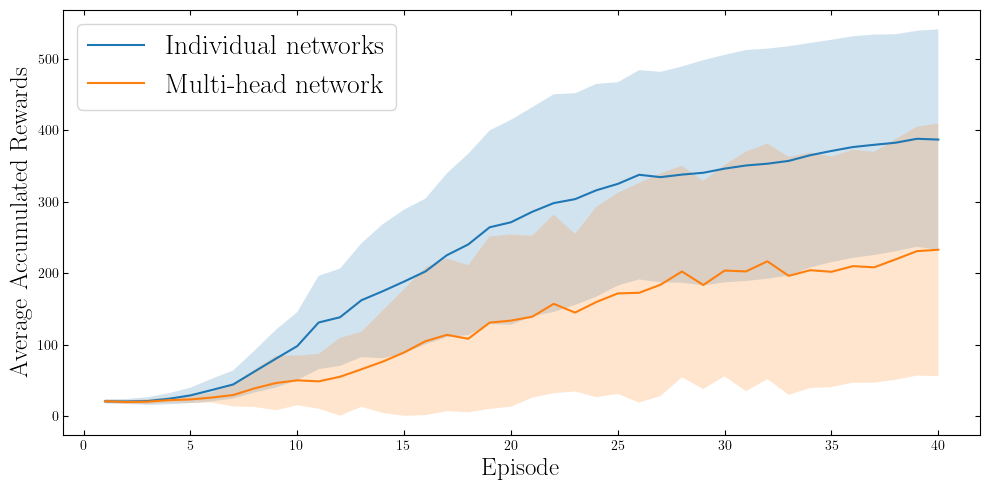

In [6]:
plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

fig, ax = plt.subplots(1,1,figsize=(10,5))
ax.plot([e+1 for e in range(num_episodes)], individual_avg, label='Individual networks')
ax.plot([e+1 for e in range(num_episodes)], multihead_avg, label='Multi-head network')
ax.fill_between([e+1 for e in range(num_episodes)], individual_avg-individual_stddev, individual_avg+individual_stddev, alpha=0.2)
ax.fill_between([e+1 for e in range(num_episodes)], multihead_avg-multihead_stddev, multihead_avg+multihead_stddev, alpha=0.2)
ax.legend(loc='upper left', fontsize=20)
ax.set_xlabel('Episode',size=18)
ax.set_ylabel('Average Accumulated Rewards',size=18)
plt.tight_layout()
plt.savefig('Comparison_2.pdf')
plt.show()